<a href="https://colab.research.google.com/github/jclauss24/MLTSA25_JClauss/blob/main/HW7/clustering_businesstimeseries_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series clustering exercise

# Data

The data is on the github repo. It can also be gotten directly from the Census Boureau and from NYC open data.

Each file is the economic census for 1 year.
Download it programmatically and move it to PUIdata

data link https://github.com/fedhere/MLTSA_FBianco/blob/main/data/nyc_zpb_est_1994_2014.csv



make sure yuo read it so that the index column is the zipcode

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.cluster import KMeans
import missingno as mno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [26]:
import matplotlib as mpl

In [3]:
# read in the business data: this is the number of licenced business per zipcode in NYC from 1994 through 2014
df = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/refs/heads/main/data/nyc_zpb_est_1994_2014.csv",index_col=0)
df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,57.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,493.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,527.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,422.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1180.0,1687.0,1736.0


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check. you should have 21(N_timestamps) datapoints per time series and about 239 zipcodes (Nzipcodes)

- drop all rows with 10 missing values or more
- impute missing values using k nearest neighbors with k=5 (you can use AI prompts to do that)


mydata.shape should be (Nzipcodes, Ntimestamps)



In [4]:
df.shape

(248, 21)

<Axes: >

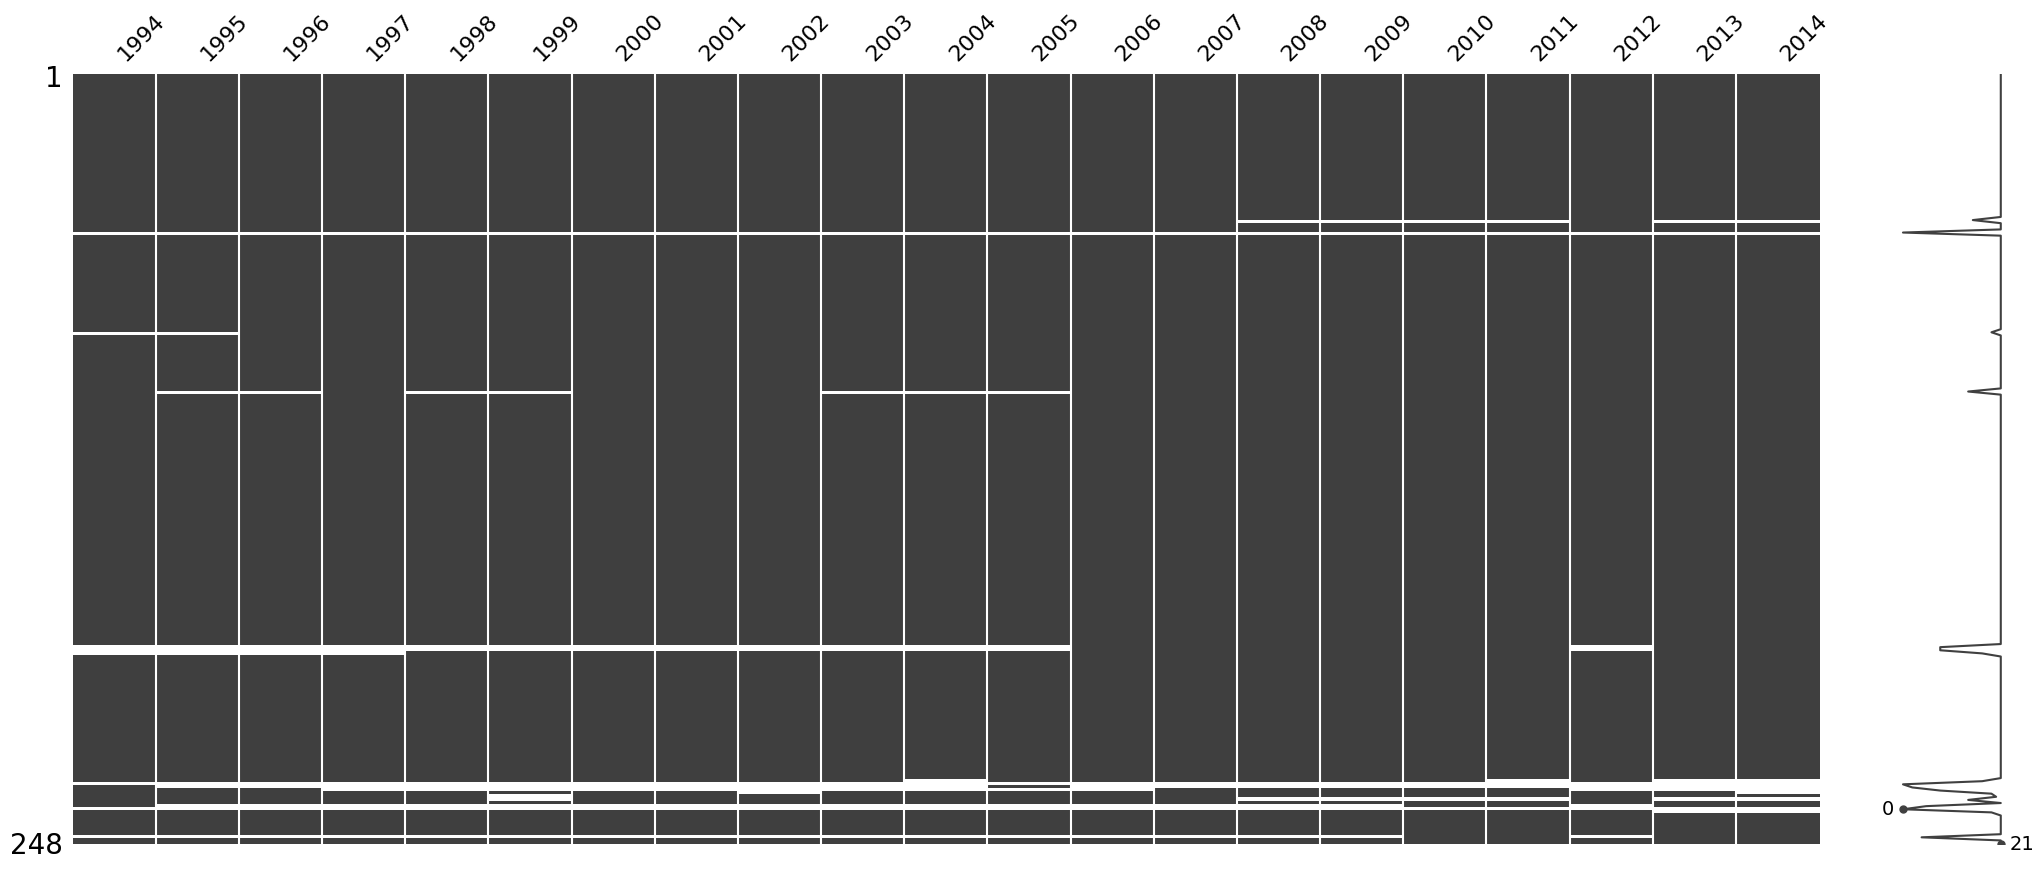

In [5]:
mno.matrix(df)

**Figure 1:** This figure shows the missing data from the dataset by year and by time series. The horizontal white lines represent the places where data is missing from the dataset. This shows that while most of the time series are complete with no missing data, there are some timeseries that have almost no data. If a time series is only missing a few datapoints scattered throughout the time, it is likely a good candidate for imputing data. However, if a time series is missing many datapoints, and especially if those missing data points are grouped together, imputing data will likely lead to innacuracy and it is likely better to disregard that particular time series.

In [6]:
df.dropna(thresh=10,inplace=True)
df.shape

(239, 21)

<Axes: >

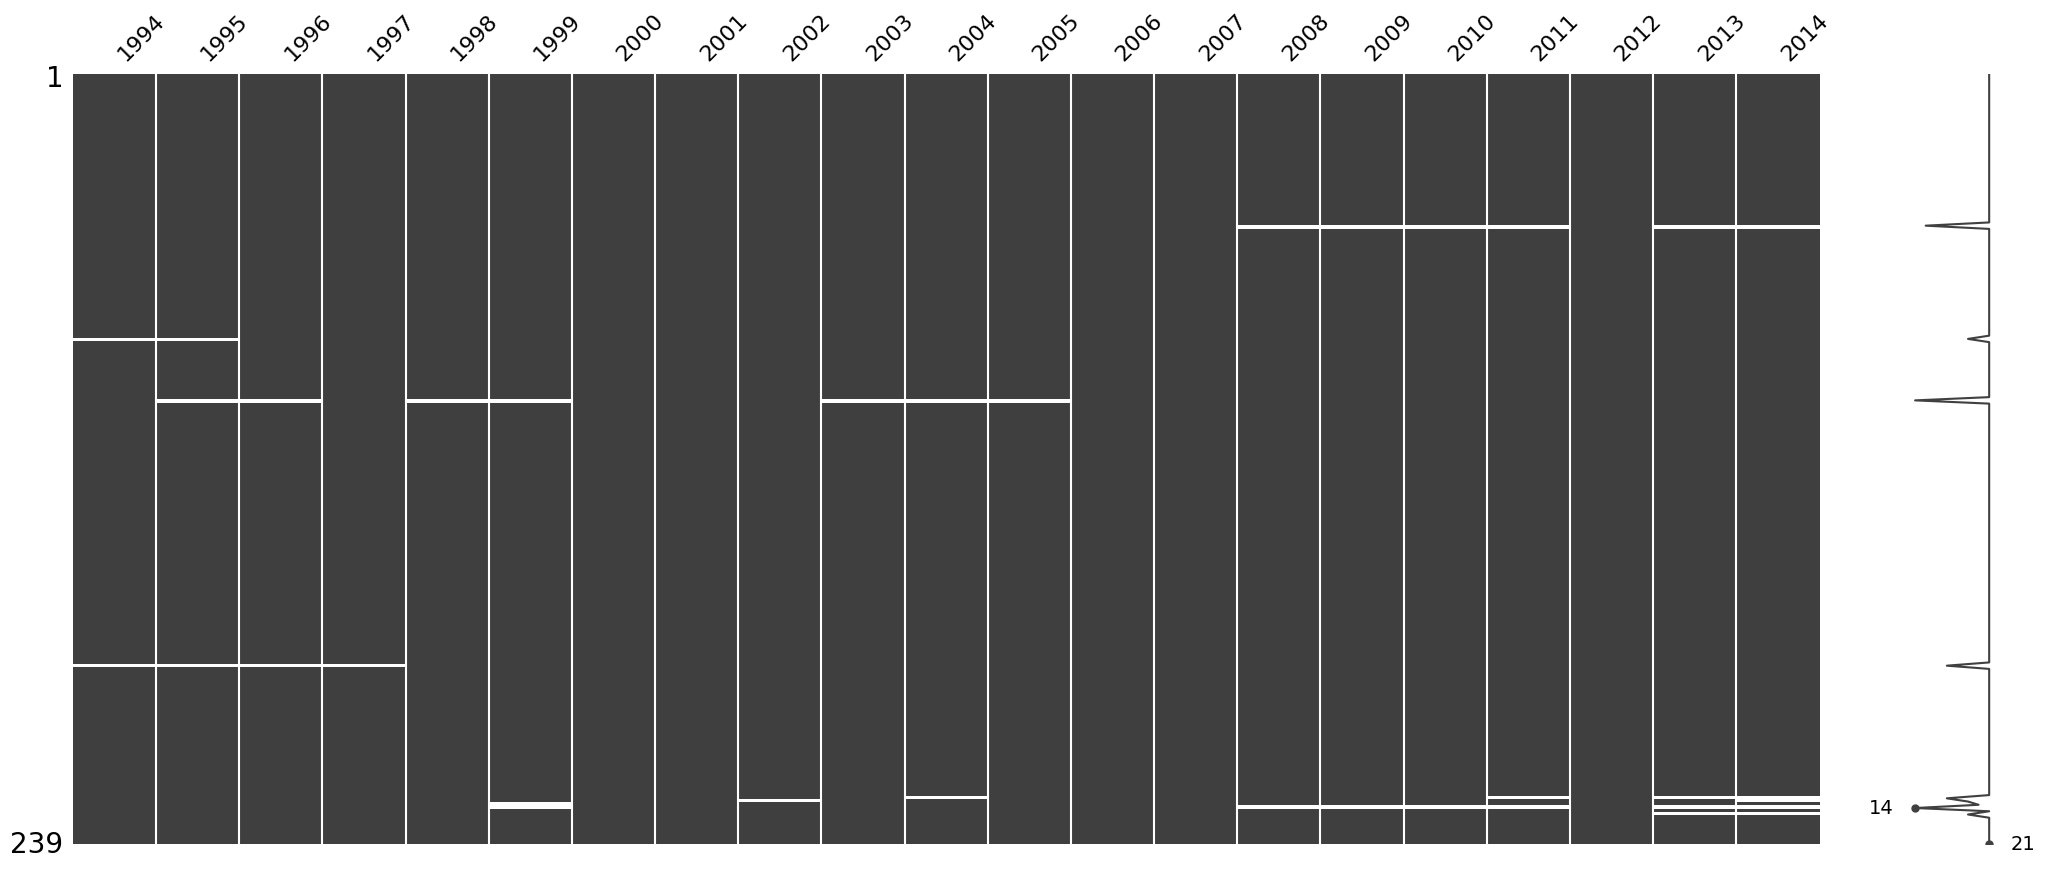

In [7]:
mno.matrix(df)

**Figure 2:** This figure is another visualization of the missing data in the dataset, similar to that seen in Figure 1. This figure is created after dropping rows with 10 or more missing data points. Because of that, we can see that the time series with missing data points in this figure have fewer missing data points than many of those in figure 1. We can also see that the missing data points tend to be scattered throughout the time series, making these time series good candidates for imputing the missing data, rather than deleting the time series entirely.

In [8]:
# prompt: impute missing values with knearest neighbors

# Initialize KNN imputer with k=5
imputer = KNNImputer(n_neighbors=5)
# Fit and transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index=df.index)

In [9]:
df_imputed.shape

(239, 21)

<Axes: >

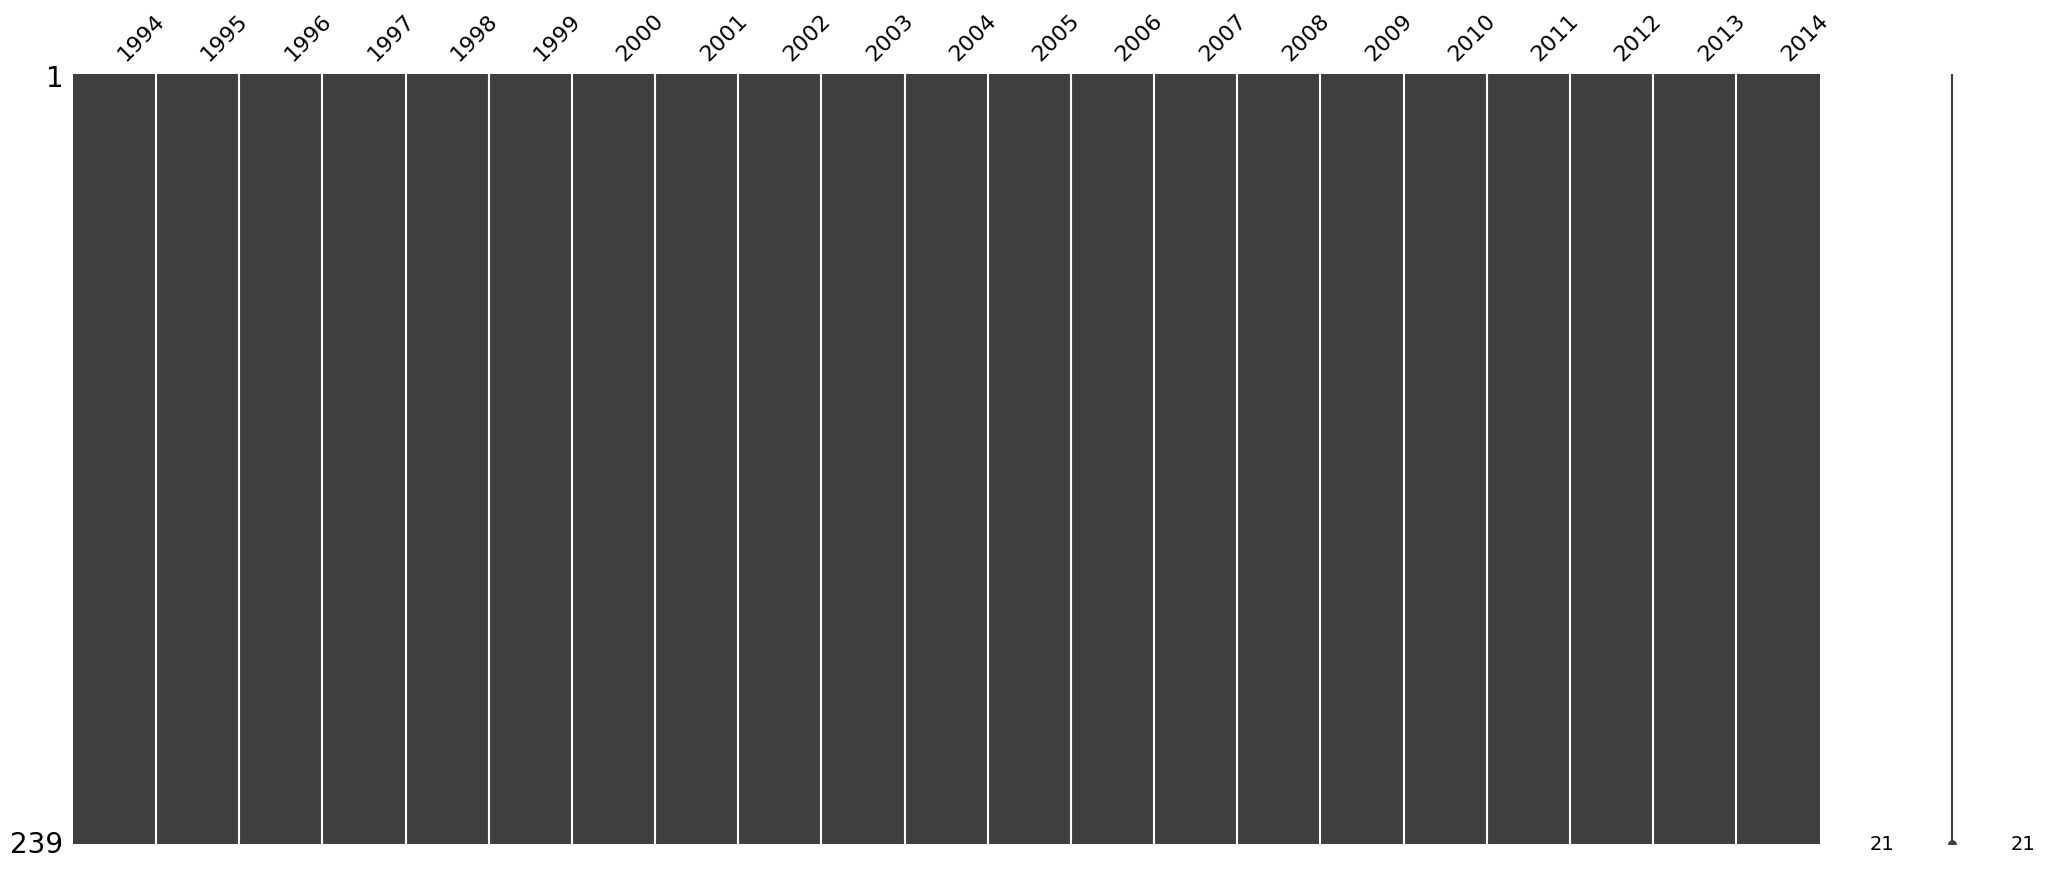

In [10]:
mno.matrix(df_imputed)

**Figue 3:** This figure is a representation of the missing data in the dataset as seen in Figures 1 and 2. This time series was created after imputing values for all missing data points. The imputation for this data was completed using a k nearest neighbor method with $k=5$. We see that this figure shows there is no missing data, as we expect since all of the missing data has now been imputed.

# get the zipcodes shape file
by cloning the repo https://github.com/wimlds/smart_cities.git


In [11]:
!git clone 'https://github.com/wimlds/smart_cities.git'

Cloning into 'smart_cities'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156 (from 1)
Receiving objects: 100% (156/156), 15.70 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (54/54), done.


original data (263, 13)
after cleaning (248, 13)
ZIPCODES: 248 POLYGONS: 248 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 248


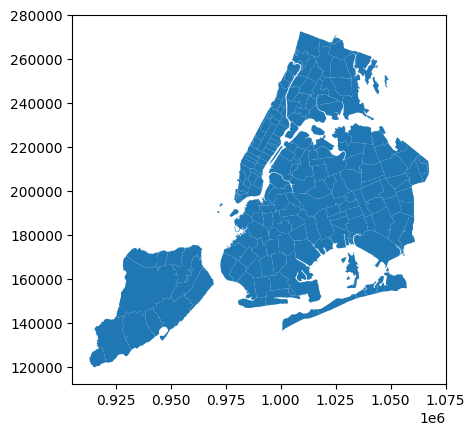

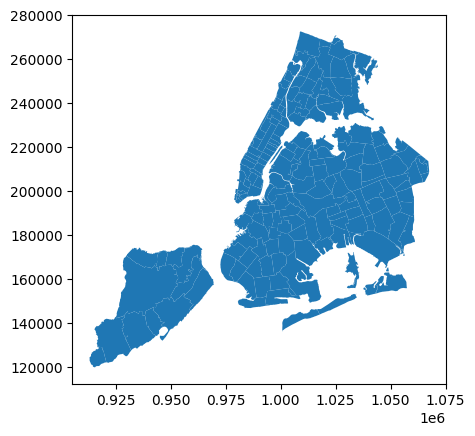

In [12]:
#look at the code and the plots below : I am using geopandas to plot maps of zipcodes from a shapefile and I am removing duplicate entries that have the same zipcode

nyczipsshp = gp.read_file( "smart_cities/NYC_shapefiles/ZIP_CODE_040114.zip")
print("original data", nyczipsshp.shape)
nyczipsshp.plot()

nyczipsshp = nyczipsshp.drop_duplicates("ZIPCODE")
print("after cleaning", nyczipsshp.shape)
nyczipsshp.plot()

print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

## TASKS:
    
    1. Scale and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to
    decide what a good number is here. try a few options, keeping in mind
    a few is more than a couple, but i recommand you stay within the
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of
    the clusters). you can plot for example the cluster centers overlayed on
    each time series (using the alpha channel to control the opacity in the
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is
    an exploratory tool so you do not want to jump to conclusions because
    you see some clusters! but seeing structure in your data can inform
    your next moves as an investigator.
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris.
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.*

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [13]:
scaler = StandardScaler()

data_t = df_imputed.transpose()
scaled_data_t = scaler.fit_transform(data_t)
vals = scaled_data_t.transpose()
scaler.mean_

array([7.44761905e+01, 5.51333333e+02, 5.85428571e+02, 4.86857143e+02,
       1.28552381e+03, 1.01100000e+03, 2.23095238e+03, 8.65809524e+02,
       1.82409524e+03, 1.68838095e+03, 3.91333333e+02, 2.85238095e+02,
       5.86476190e+02, 9.87095238e+02, 9.85095238e+02, 3.16714286e+02,
       1.48619048e+02, 5.98476190e+02, 7.24142857e+02, 9.92142857e+02,
       5.26333333e+02, 9.15285714e+02, 9.77476190e+02, 5.03285714e+02,
       5.45523810e+02, 4.57238095e+02, 1.17271429e+03, 6.72523810e+02,
       4.37571429e+02, 6.86571429e+02, 5.92142857e+02, 4.82428571e+02,
       4.64285714e+02, 5.70047619e+02, 1.31571429e+02, 4.94619048e+02,
       7.25952381e+02, 3.21952381e+02, 2.10952381e+02, 8.24095238e+02,
       6.05238095e+02, 5.83000000e+02, 1.64571429e+02, 1.92561905e+03,
       5.33047619e+02, 2.71714286e+02, 4.68285714e+02, 5.87133333e+02,
       1.85004762e+03, 8.72238095e+02, 7.96285714e+02, 6.25190476e+02,
       6.38095238e+00, 3.50285714e+02, 8.38619048e+02, 1.63909524e+03,
      

In [14]:
vals.shape
vals.mean(axis=1), vals.mean(axis=1).shape

(array([-2.85485921e-16, -3.38353684e-16, -2.11471052e-16,  3.38353684e-16,
        -4.86383420e-16, -2.11471052e-17,  6.66133815e-16, -4.75809868e-16,
         1.16309079e-16,  4.01794999e-16,  8.24737104e-16, -3.38353684e-16,
        -3.17206578e-16,  3.38353684e-16,  4.86383420e-16, -2.32618158e-16,
        -2.85485921e-16, -7.40148683e-17,  5.07530526e-16,  7.61295788e-16,
        -8.88178420e-16, -8.56457762e-16, -1.05735526e-16,  2.11471052e-16,
         1.48029737e-16, -6.34413157e-17, -1.20538500e-15,  8.45884209e-17,
         2.53765263e-16,  2.43191710e-16,  3.91221447e-16, -1.79750394e-16,
         2.11471052e-16,  1.16309079e-16, -3.27780131e-16,  6.34413157e-16,
        -2.32618158e-16, -4.01794999e-16, -4.01794999e-16,  2.74912368e-16,
         9.72766841e-16,  9.51619735e-17, -4.22942105e-16, -9.04038749e-16,
         2.32618158e-16, -6.34413157e-17,  1.05735526e-16,  8.98751972e-17,
         3.17206578e-17,  9.72766841e-16, -3.48927236e-16,  5.18104078e-16,
        -1.7

In [15]:
vals.std(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

vals.mean(axis=1) should return 0 (or something very small) everywhere [done]

vals.mean(axis=1).shape should be (248,) (Note from Skyler, not sure about this. After removing some data, seems like our set is 239)

vals.std(axis=1) should return 1 everywhere [done]



# KM Clustering

create a kmeans model with 5 clusters

In [ ]:
nc = 5
km = KMeans(n_clusters=nc, random_state=302).fit(vals)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Plot and map the clusters.

First reflect on this: the center of a cluster is a point within the cluster. If your cluster is a cluster of time series its center is... A TIME SERIES! so your cluster centers should be time series of 21 points (1995-2015)

The cluster centers are extracted as km.center

In [ ]:
km.cluster_centers_.shape

(5, 21)

In [ ]:
# testing output of km.cluster_centers_

In [ ]:
# testing output of km.cluster_centers_[1]

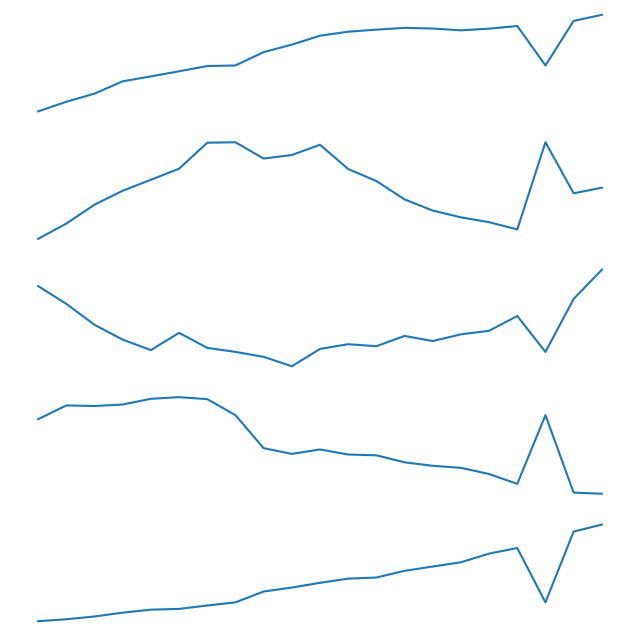

In [ ]:
#plot just the centers here
fig, axs = plt.subplots(5, 1, figsize=(8,8))

for i,c in enumerate(km.cluster_centers_):
    axs[i].plot(c, color = 'tab:blue', alpha = 1.0) # plots the cluster center

    axs[i].set_axis_off()

    # plt.axis('off')

**Figure 4:** This figure shows the cluster centers for each of the clusters resulting from kmeans clustering. This demonstrates that each cluster does have some amount of different behavior, while all of them have some sort of spike at the same late time, some of the spikes are upwards while others are downwards, and the clusters with similar spike behavior exhibit differing behavior in the time before the spike.

Then plot also the time series that belong to the cluster, overplotting them on the cluster center (cluster center in blue, alpha=1, time series in black, alpha=0.3). The time series in a cluster can be found as km.labe

In [ ]:
# testing km.labels_

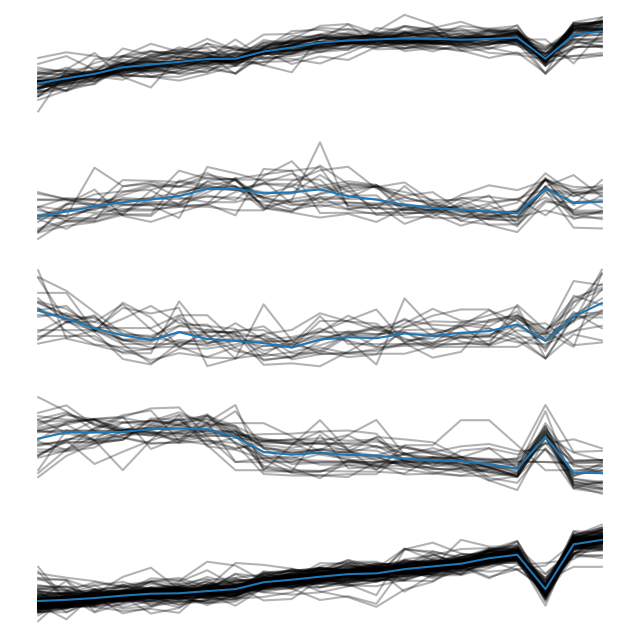

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,8))

for i,c in enumerate(km.cluster_centers_):

    # Plot all data points in cluster i
    for sample in vals[km.labels_ == i]:
        axs[i].plot(sample, color='black', alpha=0.3)

    axs[i].plot(c, color = 'tab:blue', alpha = 1.0) # plots the cluster center

    axs[i].set_axis_off()

**Figure 5:** This figure shows each of the time series belonging to each cluster, overplotted with the cluster center. The time series members of each cluster are shown as black with some transparency, while the cluster centers are shown as solid blue lines. The transparency of the time series members allows us to roughly compare how many members there are in each cluster by looking at the darkness of the overlapping lines. We see that cluster 4 (shown as the lowest series in this figure) has the highest number of members, while cluster zero (shown as the uppermost plot in this figure), has the second highest number of members.

Map the zipcodes by color according to the cluster center - you can make a single map in 5 color or 5 maps in 1 color each


In [ ]:
#create a dataframe with the cluster id per zipcode
clustersdf = pd.DataFrame()
clustersdf['ZIPCODE'] = df_imputed.index.astype(str)
clustersdf['cluster'] = km.labels_
clustersdf.head()

,ZIPCODE,cluster
0,11436,4
1,11213,4
2,11212,4
3,11225,4
4,11218,4


In [ ]:
#merge it with the geodataframe with the zipcode shapes- I am losing 1 zipcode...
mergednyz = nyczipsshp.merge(clustersdf, on='ZIPCODE', how='inner')
print("length of dataframes:",
      len(mergednyz.ZIPCODE),
      len(np.unique(clustersdf.ZIPCODE)), len(np.unique(nyczipsshp.ZIPCODE)))

length of dataframes: 239 239 248


Note from Yuca: from earlier preprocessing, it seems like we are losing ~9 zipcodes here instead of one (that the professor loses in her homework setup)

/tmp/ipykernel_31/1159410810.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' * len(ax.get_xticklabels())])


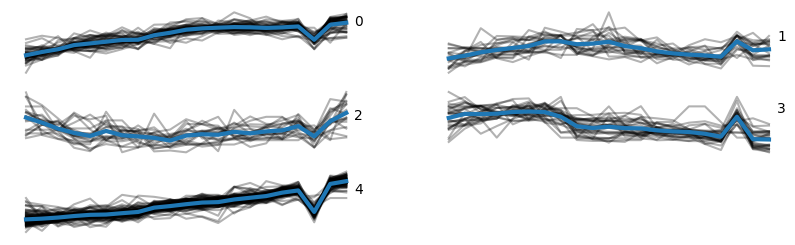

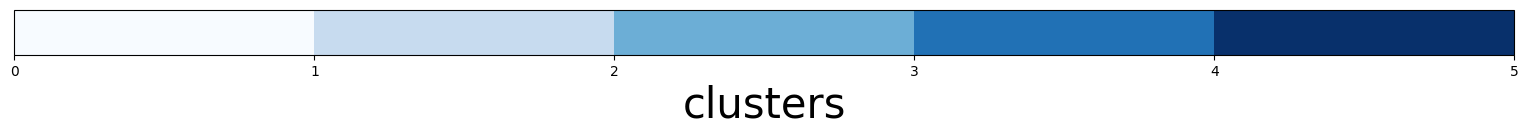

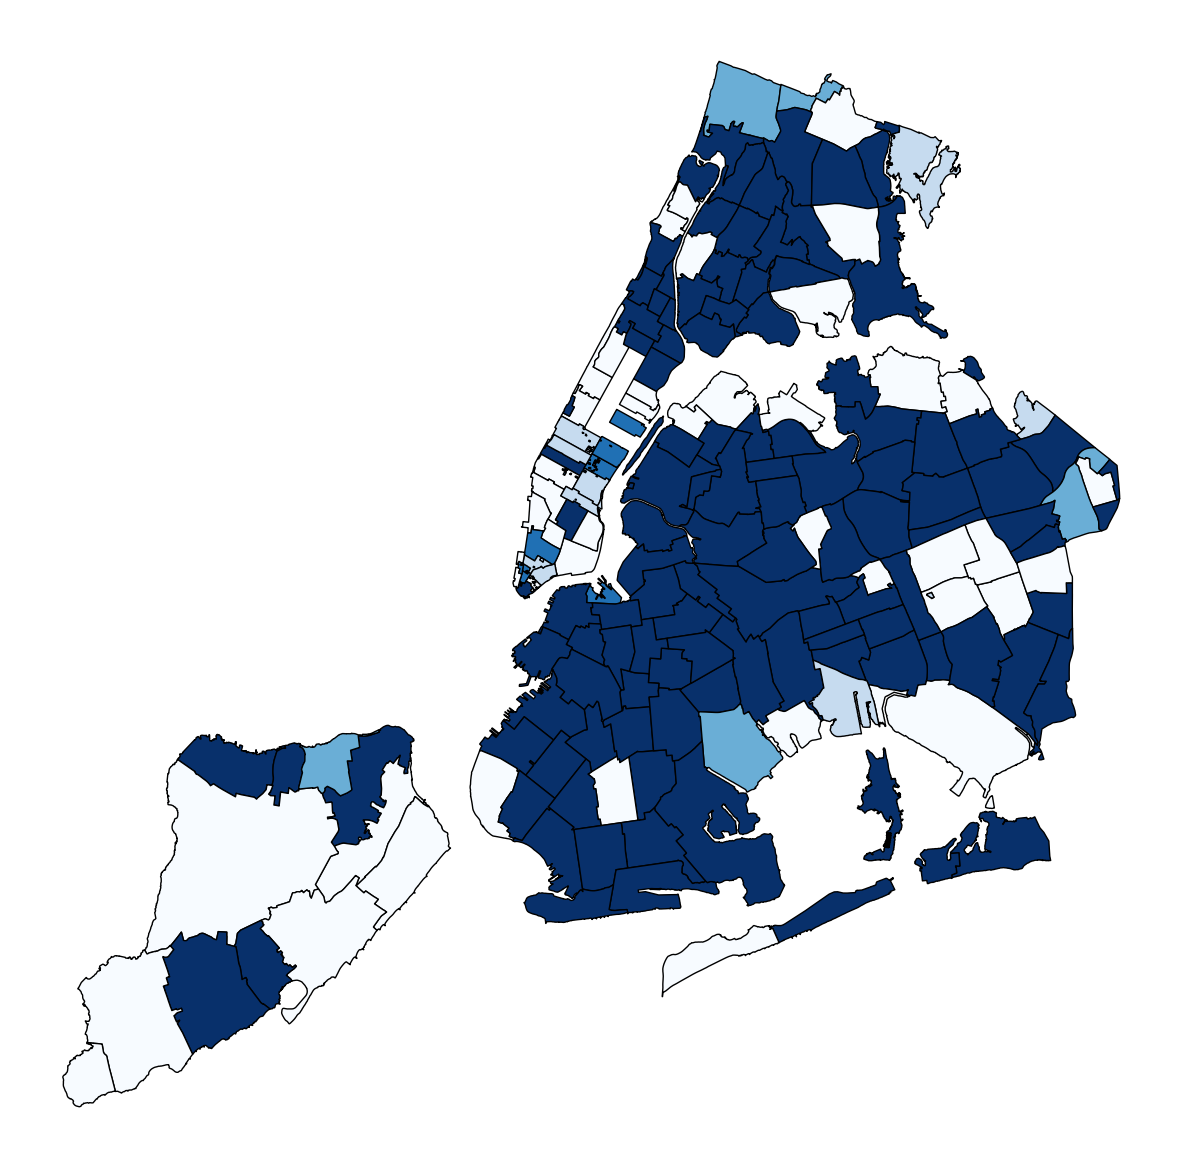

In [ ]:
import matplotlib as mpl
fig = plt.figure(figsize=(10, 5))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))

    for v in vals[km.labels_ == i]:
        ax.plot(np.arange(1994, 2015, 1), v, 'k-', alpha=0.3)
    ax.text(2014.5, 1, "%d" % i)

    plt.xticks(fontsize=10)
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    ax.plot(np.arange(1994, 2015, 1), Xc, lw=3)
    plt.grid(False)
    plt.axis('off')
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.
bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
mergednyz.plot(column='cluster', cmap='Blues', alpha=1, ax=ax, ec='k')
tmp = ax.axis('off')

**Figure 6:** The upper part of this figure shows each time series in each cluster, with the center of each cluster overlayed. This is described and shown in Figur 5. The lower part of this figure shows a map of the zipcodes, colored according to the cluster that they are a member of. We see that many of the zip codes belong to clusters 0 and 4, as expected from the plotting of the member clusters. We also see that there appears to be some sort of geographical grouping.

Clusters 0,2,and 4 are the clusters that exhibit a downward spike in the the number of registerred businesses in the year 2012, while clusters 1 and 3 are those that experience and upward spike that same year. In examining this map of the clusters, we can see that the majority of zip codes in clusters 1 and 3 are located in Manhattan, while the other boroughs are dominated by clusters that experienced a downward spike. This shows that while other boroughs had less registered businesses in this year, Manhattan had an increase in number of businesses that same year.

### Figure 3:
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

Can you parse some business and socioeconomic dynamics from this plot?

create 8 kmeans models with 2-10 cluster centers. put each model in a list

(array([0, 1], dtype=int32), array([185,  54]))
(array([0, 1, 2], dtype=int32), array([ 19,  46, 174]))
(array([0, 1, 2, 3], dtype=int32), array([ 19,  32, 170,  18]))
(array([0, 1, 2, 3, 4], dtype=int32), array([ 50,  21,  19,  28, 121]))
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 14,  18,  47,  23, 124,  13]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([121,  15,  50,   8,  15,  18,  12]))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([121,  17,  11,  11,  49,   9,   6,  15]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([73, 15, 19,  5, 15,  7, 79, 10, 16]))


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

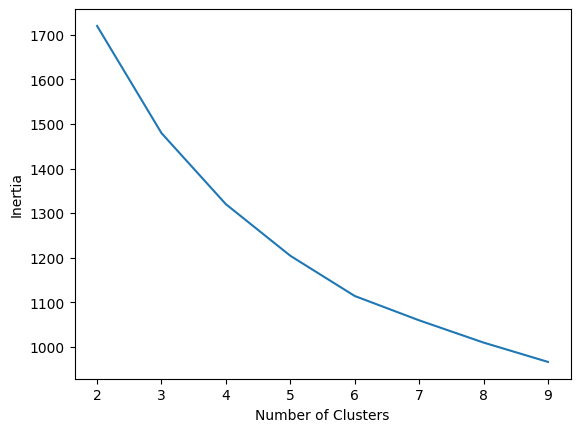

In [ ]:
kms = []

for nc in range(2,10):
  #cluster with kmeans
  kms.append(KMeans(n_clusters=nc, random_state=302).fit(vals))


#each observation in the km object has a label:
#that is the cluster assigned to that observation
for km in kms:
  print(np.unique(km.labels_, return_counts=True))


import pylab as plt
# note from yuca: from documentation website,
# "inertia (float): Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided."
plt.plot(range(2,10), [km.inertia_ for km in kms])
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

**Figure 7:** This figure shows the inertia, a number that represents the closeness of each member of each cluster to its cluster center, plotted against the number of clusters used. This can be used to help determine how many clusters should be used. To determine how many clusters should be used, we look for an "elbow" or a place in the plot where the slope of the plot becomes less steep. Upon visual inspection, the plot does not appear to have a noticable elbow at 5 clusters, with a slightly more apparent elbow appearing at 6 clusters. This indicates that 6 clusters may have been a more useful hyperparameter to use.

QUESTION: was the number 5 clusters justified by the data? explain

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

# repeating the exercise using DBSCAN or hyerarchical agglomerative clustring...

In [16]:
# note from Yuca: trying DBSCAN, you do not specify the number of clusters you want for the way DBSCAN works
# since DBSCAN "finds core samples of high density and expands clusters from them" (from their documentation online)
# documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

from sklearn.cluster import DBSCAN

"""
epsfloat, default=0.5
The maximum distance between two samples for one to be considered as in the neighborhood of the other.
This is not a maximum bound on the distances of points within a cluster.
This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

min_samplesint, default=5
The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.
"""


db = DBSCAN(eps=3.5, min_samples=2).fit(vals)

For eps = 3.5 and min_samples = 2:

In [17]:
db.core_sample_indices_.shape

(221,)

In [18]:
print(db.core_sample_indices_)

[  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  94
  95  96  97  98  99 100 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 189 192 193 194 195 196 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 218 219 224 226 227 228 229 230 231
 232 233 234 236 238]


In [19]:
db.components_.shape

(221, 21)

In [20]:
db.labels_.shape

(239,)

In [21]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
       -1, -1, -1,  0, -1

[ 0 -1]


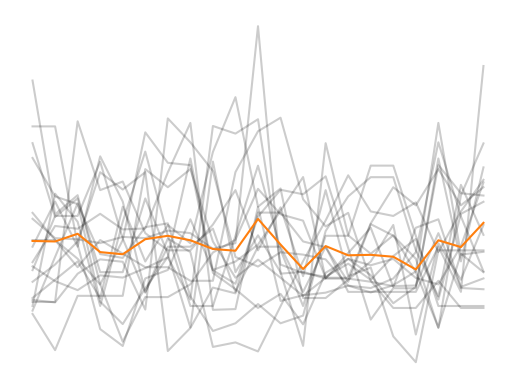

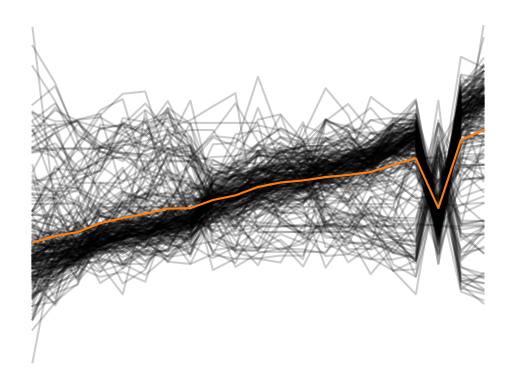

In [22]:
# Get cluster labels
labels = db.labels_

# Add cluster labels to the DataFrame
vals_pd = pd.DataFrame(vals)
vals_pd['cluster'] = labels
print(vals_pd['cluster'].unique())

# Now you can analyze the clusters as you did with KMeans
# For example:
# Visualize clusters
# ax = vals_pd[vals_pd.cluster == -1].drop("cluster", axis=1).T.plot(legend=False, color="k", alpha=0.2)
for l in range(-1, vals_pd['cluster'].max()+1):
    if len(vals_pd[vals_pd.cluster == l]) == 0:
        continue

    vals_pd[vals_pd.cluster == l].drop("cluster", axis=1).T.plot(legend=False, color='black', alpha=0.2)

    cluster_data = vals_pd[vals_pd.cluster == l].drop("cluster", axis=1)
    cluster_center = cluster_data.mean(axis=0)
    plt.plot(cluster_center.values, color='tab:orange', alpha=1.0)
    plt.axis('off')
    plt.show()

    # cluster_center = vals_pd[vals_pd.cluster == l].mean(axis=0)  # Calculate the "center" of the cluster
    # axs[i].plot(cluster_center, color='tab:orange', alpha=1.0)  # Plot the cluster "center"

**Figure 8:** This figure shows the time series in each cluster, with the cluster center overlayed in orange produced by the results of using DBSCAN with parameters eps = 3.5 and min_samples = 2. The first cluster shown is the noise/outliers group, while the second cluster is the actual cluster. WE see that it has grouped the large majority of the timetserie into one cluster, even when they have very distinct shapes from each other. This is a demonstration of how sensitive the DBSCAN method is to the hyperparameters eps and min_samples.

In [23]:
#create a dataframe with the cluster id per zipcode
clustersdf = pd.DataFrame()
clustersdf['ZIPCODE'] = df_imputed.index.astype(str)
clustersdf['cluster'] = db.labels_
clustersdf.head()

,ZIPCODE,cluster
0,11436,0
1,11213,0
2,11212,0
3,11225,0
4,11218,0


In [24]:
#merge it with the geodataframe with the zipcode shapes- I am losing 1 zipcode...
mergednyz = nyczipsshp.merge(clustersdf, on='ZIPCODE', how='inner')
print("length of dataframes:",
      len(mergednyz.ZIPCODE),
      len(np.unique(clustersdf.ZIPCODE)), len(np.unique(nyczipsshp.ZIPCODE)))

length of dataframes: 239 239 248


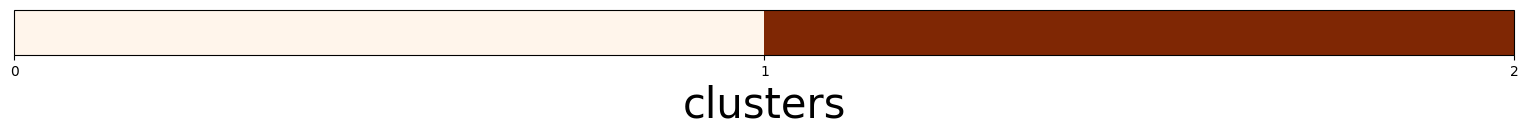

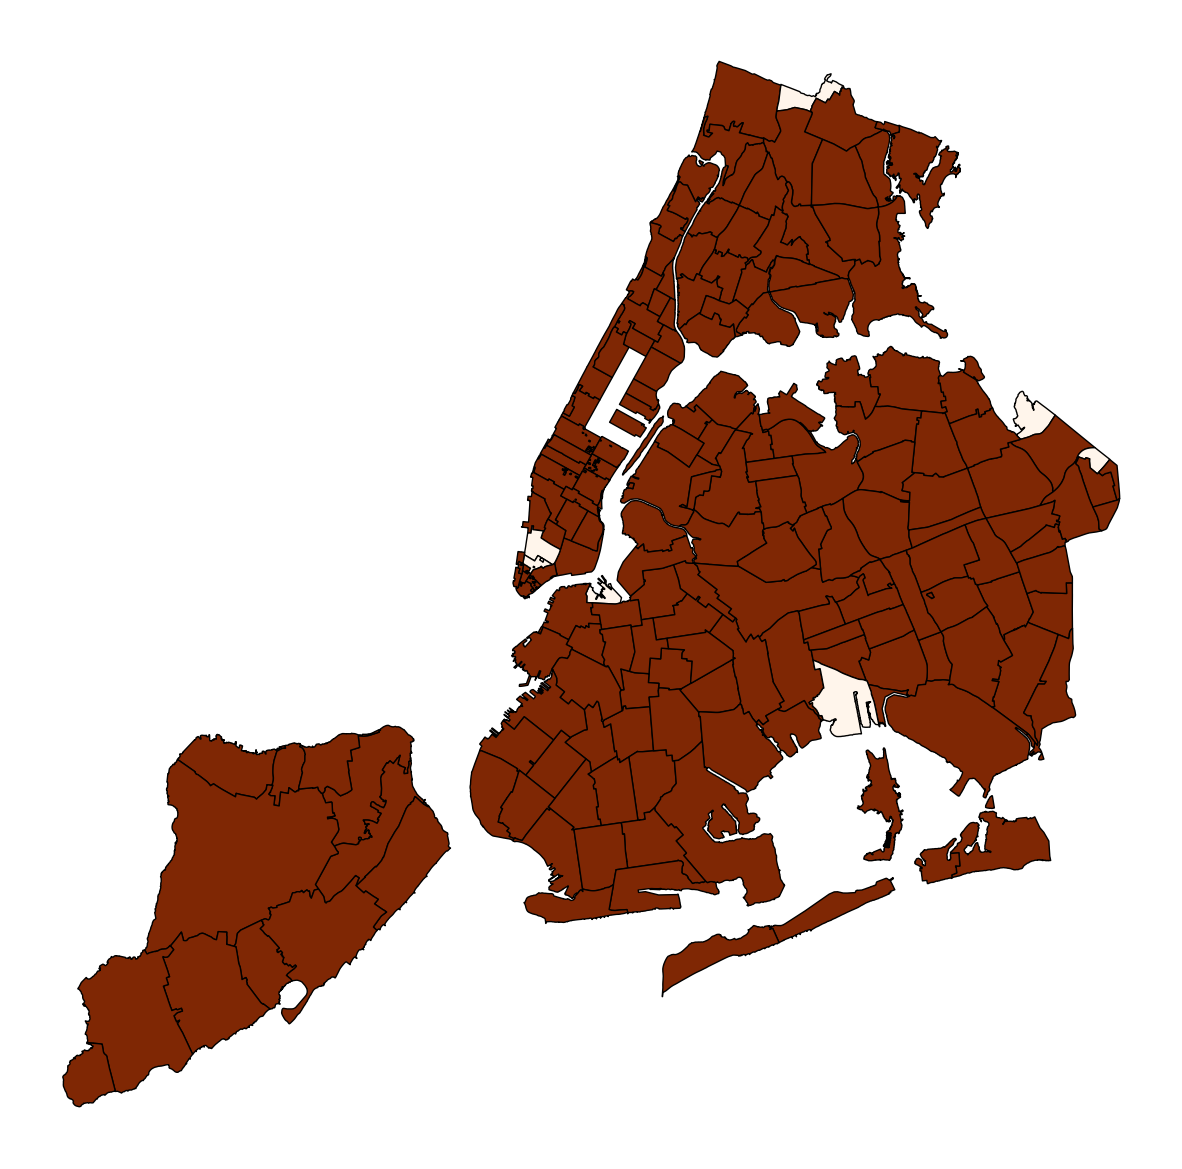

In [27]:
# import matplotlib as mpl
# fig = plt.figure(figsize=(10, 5))
# for i, Xc in enumerate(km.cluster_centers_):
#     ax = fig.add_subplot(5, 2, (i + 1))

#     for v in vals[km.labels_ == i]:
#         ax.plot(np.arange(1994, 2015, 1), v, 'k-', alpha=0.3)
#     ax.text(2014.5, 1, "%d" % i)

#     plt.xticks(fontsize=10)
#     ax.set_yticklabels(['' * len(ax.get_xticklabels())])
#     ax.plot(np.arange(1994, 2015, 1), Xc, lw=3)
#     plt.grid(False)
#     plt.axis('off')
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Oranges
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.
bounds = range(2 + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
mergednyz.plot(column='cluster', cmap='Oranges', alpha=1, ax=ax, ec='k')
tmp = ax.axis('off')

**Figure 9:** This figure shows the map of New York colored by cluser found from the results of using DBSCAN with parameters eps = 3.5 and min_samples = 2. The zipcodes shown in pale orange are those determined to be noise. The zipcoees determined to be in cluster 0 are shown in dark orange. We see that it has grouped the large majority of the timetserie into one cluster, even when they have very distinct shapes from each other. This is a demonstration of how sensitive the DBSCAN method is to the hyperparameters eps and min_samples.

For eps = 2.5 and min_samples = 2:

[ 0 -1  1  2]


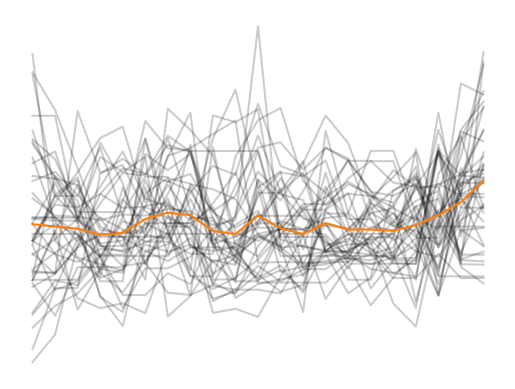

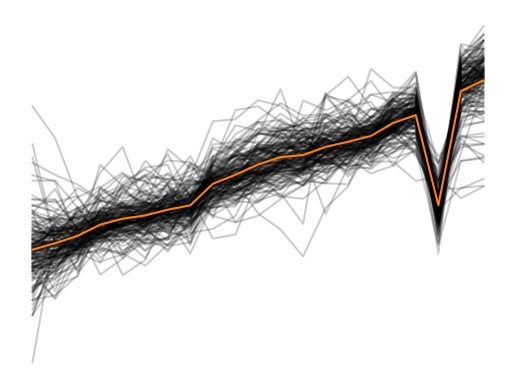

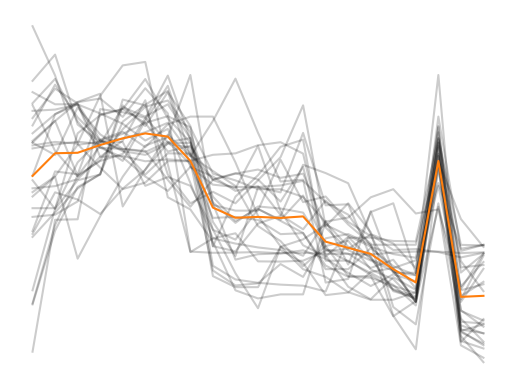

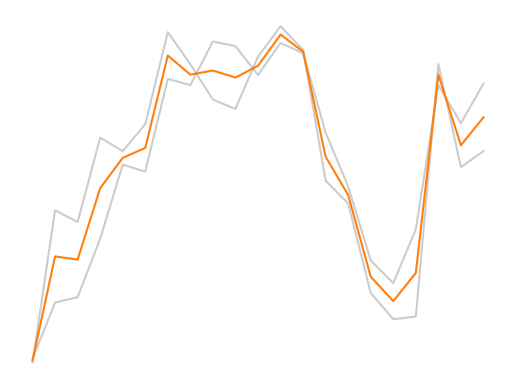

In [28]:
db = DBSCAN(eps=2.5, min_samples=2).fit(vals)

# Get cluster labels
labels = db.labels_

# Add cluster labels to the DataFrame
vals_pd = pd.DataFrame(vals)
vals_pd['cluster'] = labels
print(vals_pd['cluster'].unique())

# Now you can analyze the clusters as you did with KMeans
# For example:
# Visualize clusters
# ax = vals_pd[vals_pd.cluster == -1].drop("cluster", axis=1).T.plot(legend=False, color="k", alpha=0.2)
for l in range(-1, vals_pd['cluster'].max()+1):
    if len(vals_pd[vals_pd.cluster == l]) == 0:
        continue

    vals_pd[vals_pd.cluster == l].drop("cluster", axis=1).T.plot(legend=False, color='black', alpha=0.2)

    cluster_data = vals_pd[vals_pd.cluster == l].drop("cluster", axis=1)
    cluster_center = cluster_data.mean(axis=0)
    plt.plot(cluster_center.values, color='tab:orange', alpha=1.0)
    plt.axis('off')
    plt.show()

    # cluster_center = vals_pd[vals_pd.cluster == l].mean(axis=0)  # Calculate the "center" of the cluster
    # axs[i].plot(cluster_center, color='tab:orange', alpha=1.0)  # Plot the cluster "center"

**Figure 10:** This figure shows the time series in each cluster, with the cluster center overlayed in orange produced by the results of using DBSCAN with parameters eps = 2.5 and min_samples = 2. The first cluster shown is the noise/outliers group, and 3 additional clusters were found. We can see that DBSCAN has found one group with an upward spike in the data and one cluster with a downward spike in the data. The final cluster shown should more likely be considered noise than its own group. This was the most reasonable clustering we were able to get as output from DBSCAN due to how sensitive it is to the choice of hyperparameters. We can still see that in the noise group there are many time series with a definite upwards or downwards spike which should likely be grouped together, but instead have been categorized as noise.

length of dataframes: 239 239 248


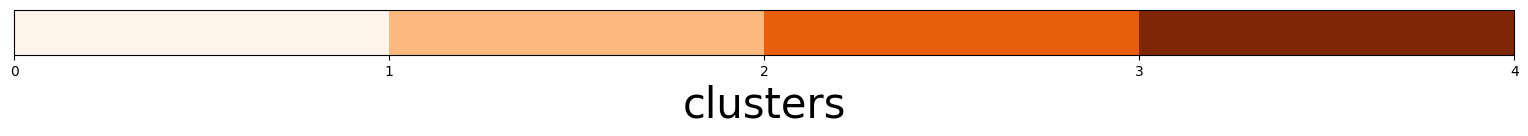

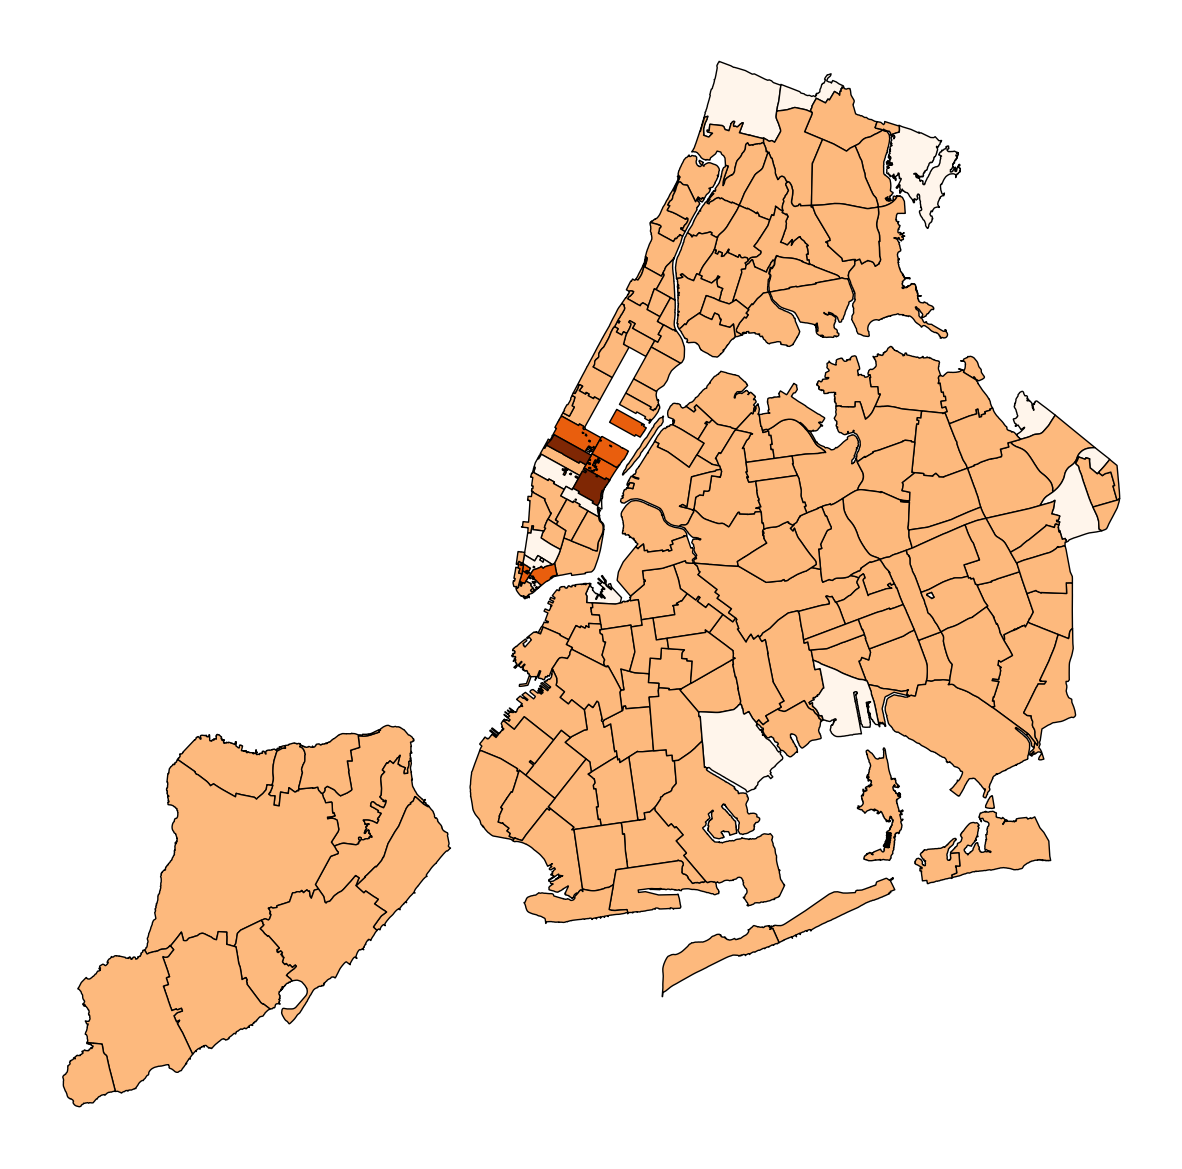

In [31]:
clustersdf['cluster'] = db.labels_

#merge it with the geodataframe with the zipcode shapes- I am losing 1 zipcode...
mergednyz = nyczipsshp.merge(clustersdf, on='ZIPCODE', how='inner')
print("length of dataframes:",
      len(mergednyz.ZIPCODE),
      len(np.unique(clustersdf.ZIPCODE)), len(np.unique(nyczipsshp.ZIPCODE)))

fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Oranges
norm = mpl.colors.Normalize(vmin=0, vmax=5)

bounds = range(4 + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
mergednyz.plot(column='cluster', cmap='Oranges', alpha=1, ax=ax, ec='k')
tmp = ax.axis('off')

**Figure 11:** This figure shows the map of New York colored based on the clusters produced by the results of using DBSCAN with parameters eps = 2.5 and min_samples = 2. The first cluster shown is the noise/outliers group, and 3 additional clusters were found. We can see that DBSCAN has found one group with an upward spike in the data and one cluster with a downward spike in the data. The cluster containing the downward spike is labeled as cluster 1 in this figure, and contains the majority of the zip code. The cluster characterized by an upward spike is labeled as cluster 2 in this figure. The final cluster shown, labeled as cluster 3 in this figure, should more likely be considered noise than its own group. This was the most reasonable clustering we were able to get as output from DBSCAN due to how sensitive it is to the choice of hyperparameters.

For eps = 3.5 and min_samples = 1:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


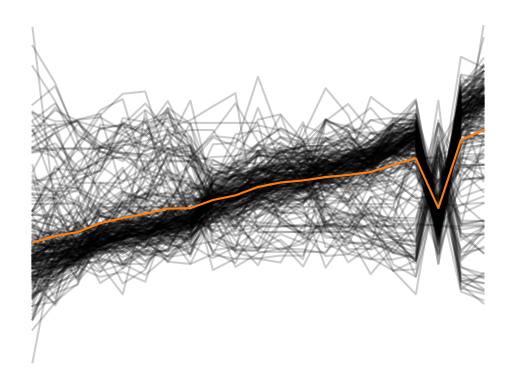

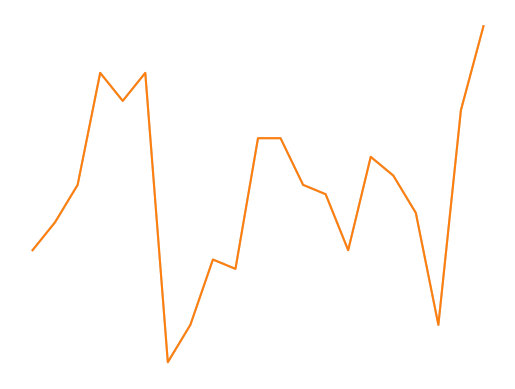

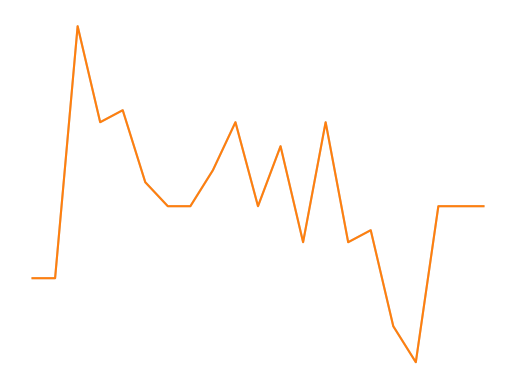

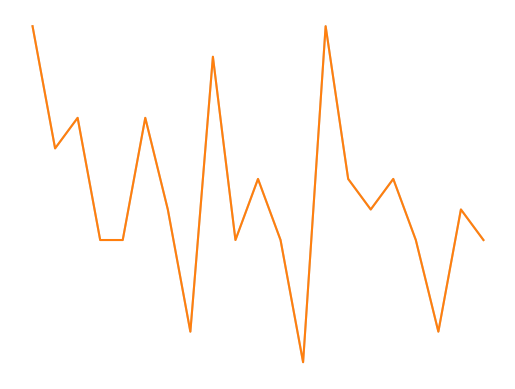

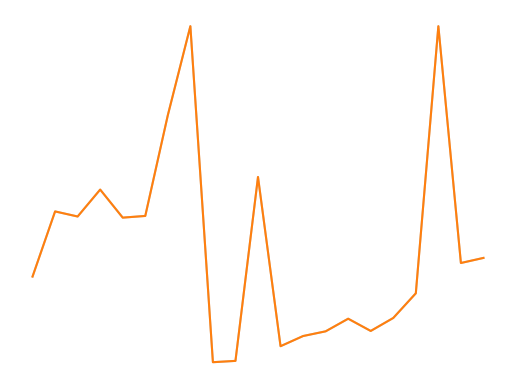

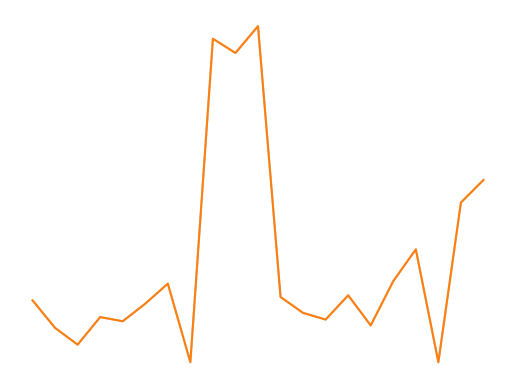

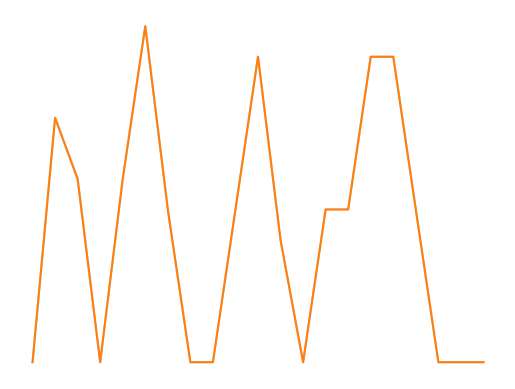

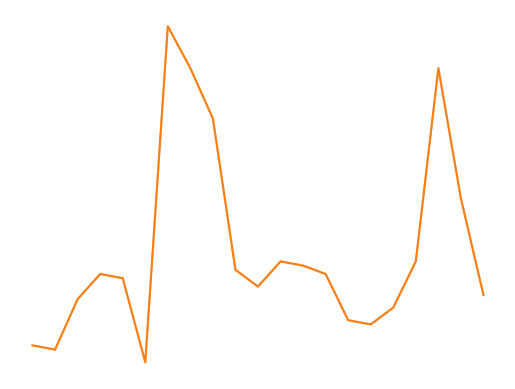

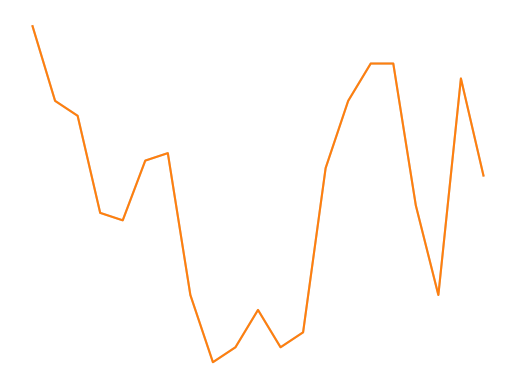

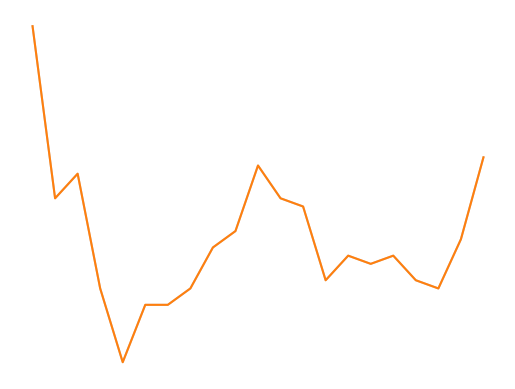

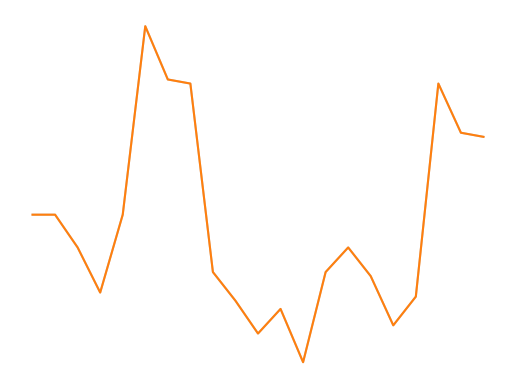

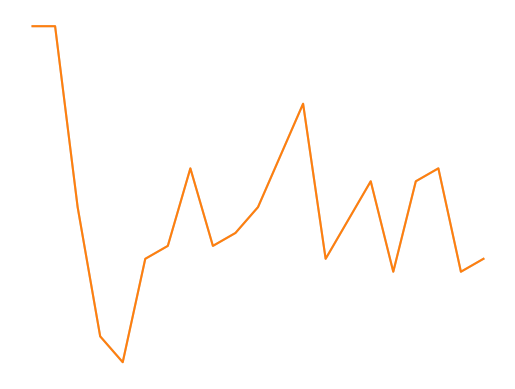

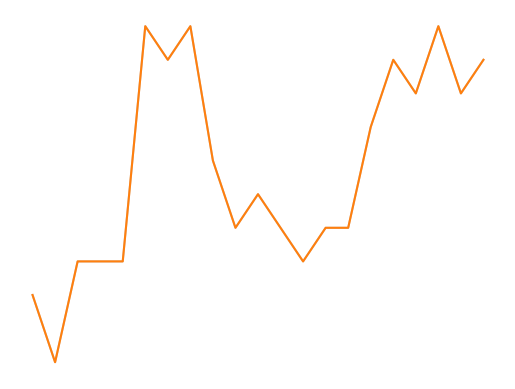

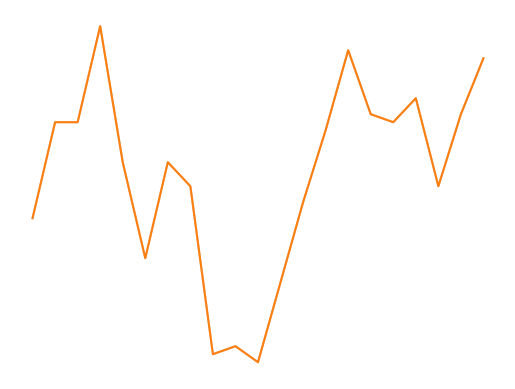

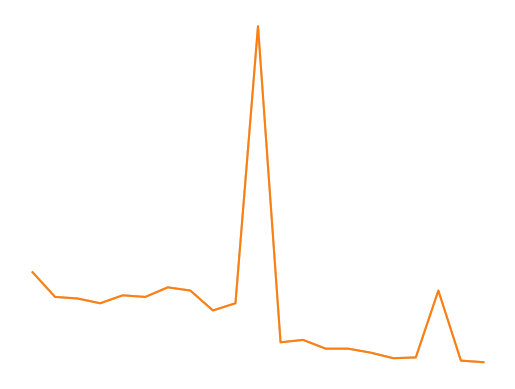

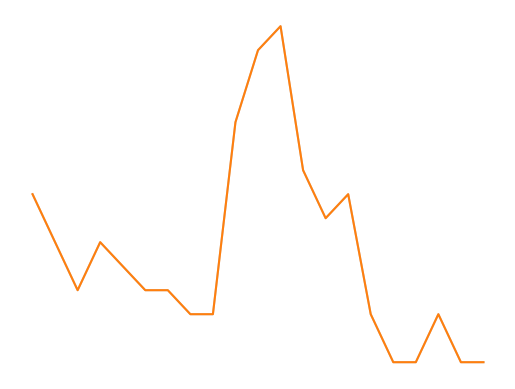

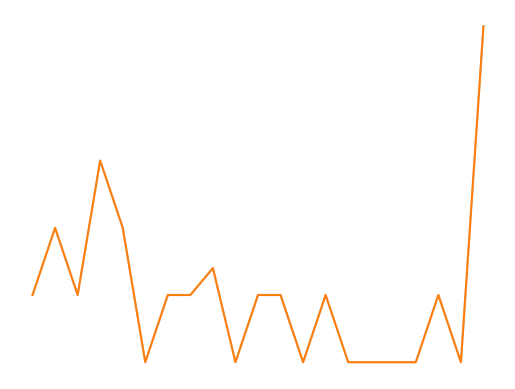

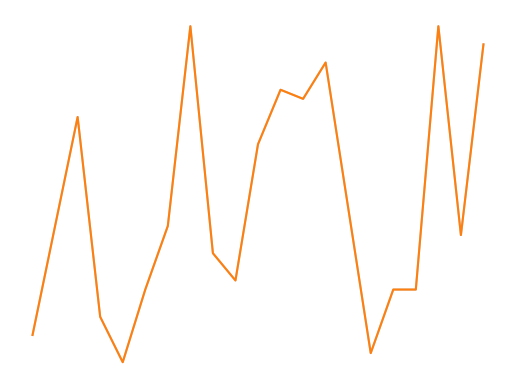

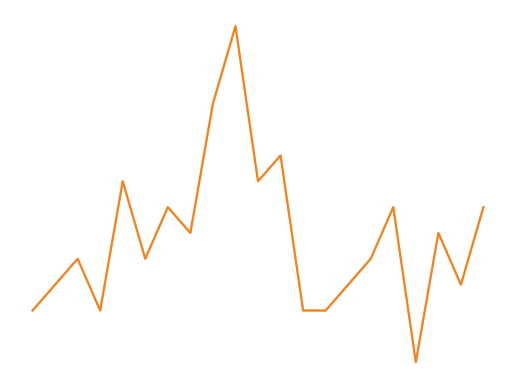

In [33]:
db = DBSCAN(eps=3.5, min_samples=1).fit(vals)

# Get cluster labels
labels = db.labels_

# Add cluster labels to the DataFrame
vals_pd = pd.DataFrame(vals)
vals_pd['cluster'] = labels
print(vals_pd['cluster'].unique())

# Now you can analyze the clusters as you did with KMeans
# For example:
# Visualize clusters
# ax = vals_pd[vals_pd.cluster == -1].drop("cluster", axis=1).T.plot(legend=False, color="k", alpha=0.2)
for l in range(-1, vals_pd['cluster'].max()+1):
    if len(vals_pd[vals_pd.cluster == l]) == 0:
        continue

    vals_pd[vals_pd.cluster == l].drop("cluster", axis=1).T.plot(legend=False, color='black', alpha=0.2)

    cluster_data = vals_pd[vals_pd.cluster == l].drop("cluster", axis=1)
    cluster_center = cluster_data.mean(axis=0)
    plt.plot(cluster_center.values, color='tab:orange', alpha=1.0)
    plt.axis('off')
    plt.show()

    # cluster_center = vals_pd[vals_pd.cluster == l].mean(axis=0)  # Calculate the "center" of the cluster
    # axs[i].plot(cluster_center, color='tab:orange', alpha=1.0)  # Plot the cluster "center"

**Figure 12:** This figure shows the time series in each cluster, with the cluster center overlayed in orange produced by the results of using DBSCAN with parameters eps = 3.5 and min_samples = 1. The first cluster shown is the noise/outliers group, and 17 additional clusters are shown. We see that it has grouped the large majority of the time series into the noise group, and created many clusters only containing one time series. This is a demonstration of how sensitive the DBSCAN method is to the hyperparameters eps and min_samples.

length of dataframes: 239 239 248


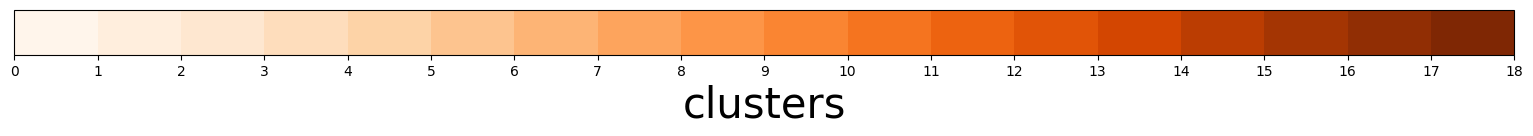

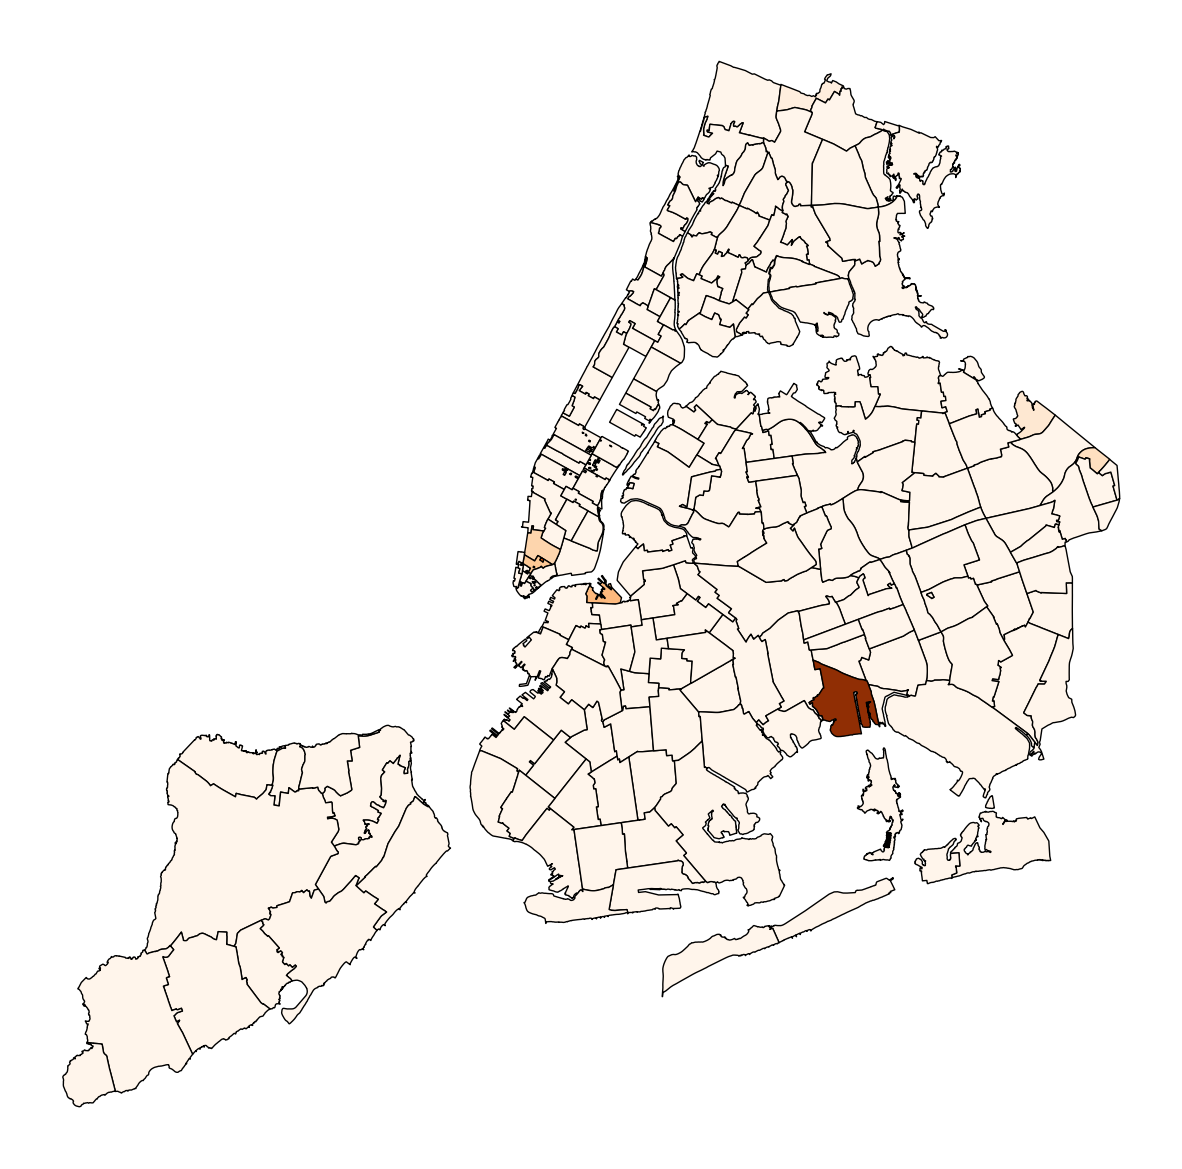

In [34]:
clustersdf['cluster'] = db.labels_

#merge it with the geodataframe with the zipcode shapes- I am losing 1 zipcode...
mergednyz = nyczipsshp.merge(clustersdf, on='ZIPCODE', how='inner')
print("length of dataframes:",
      len(mergednyz.ZIPCODE),
      len(np.unique(clustersdf.ZIPCODE)), len(np.unique(nyczipsshp.ZIPCODE)))
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Oranges
norm = mpl.colors.Normalize(vmin=0, vmax=5)

bounds = range(18 + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
mergednyz.plot(column='cluster', cmap='Oranges', alpha=1, ax=ax, ec='k')
tmp = ax.axis('off')

**Figure 13:** This figure shows map of New York by zip code, colored by the cluster of each zip code, which were the  results of using DBSCAN with parameters eps = 3.5 and min_samples = 1. The first cluster shown is the noise/outliers group, labeled as cluster 0 in this figure, and 17 additional clusters are shown. We can see that it has grouped the large majority of the time series into the noise group, and created many clusters only containing one time series. These are shown as seemingly random, scattered zip codes in other cluters. This is a demonstration of how sensitive the DBSCAN method is to the hyperparameters eps and min_samples.

### Figure 9:
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [ ]:
....

SyntaxError: invalid syntax (1805539695.py, line 1)

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

In [ ]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


In [ ]:
!pwd